# Re-activation test model

## Overview:

You are being provided a file with combined series of historical mail promotional files.  The purpose of these campaigns are to “re-activate” people who used to donate a lot to a charity, however in recent months or years have stopped giving. Heuristic financial information from within many charities suggest that there is a lower cost to raise a dollar by re-activating lapsed donors then say acquiring a cold donor who is unfamiliar with the charity.  Many charities have large lapsed data segments in their databases making this a field of strong interest for the charity.

## Goal:

Generally your goal in a production scenario could be to use a model to drive the most names (largest lapsed mailing) possible at break even, since long term value suggests re-activated donors go on to become very valuable.
<br><br>
In the interest of brevity we will only be looking at Area under the ROC to determine success and keep the task simple in its goal.  Although, the actual response amount (GIFT) is provided in the data (except for blind validation file), this is going to be response driven only.
<br><br>
Although we are looking to see your model “work”, we are most interested in your process, questions you may have as you work, creativity and process.  So aside from delivering the blind validation file, please deliver any notes and data visualizations from the project so we can follow your thought process.  In other words sell us on your methodology. 
<br><br>
You may use any learning algorithm of your choosing and environment.  Although, this is a classic supervised learning scenario, we are not putting any constraints on how you choose to build a solution. 

## Data:

You have 2 files provided.  1 for training and validation and 1 for blind validation to send us back when you have provided a score.
<br><br>
Much of the work on the data has been done for you.  Using the client’s internal database we have created accurate snapshots for you of what the data looked like for each campaign at the time it was sent with of course who responded.   As a ‘data scientist’ with VeraData you will be provided with an expert to handle ETL and work with you so you can focus on the actual analytics.
<br><br>
Also, in the interest of time as well as computational resource efficiency, we have limited the variables provided to you and the number of records you have in your file.  This will make the data easier for you to manage as apposed to the 1000+ variables and 1000000+ records that will be available to you in a production environment.  As mentioned before we are more looking to assess your thought process not burn up your personal computer. You are provided below with the description of some client’s fields and the most other fields are third-party data that we received without descriptions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('./mail-promotion/mail-promotion/data/train.csv', delimiter='|')
test_df = pd.read_csv('./mail-promotion/mail-promotion/data/test.csv', delimiter='|')

In [3]:
train_df.head()

,Unnamed: 0,VC_ID,VC_DATEMAIL,VC_DATERESP,VC_GIFT,VC_CATHA,VC_CATHMC,PX_WO_CRR,PX_WO_CRR6MTH,ax_donation_contribution_c,...,ax_scuba_diving,ax_adult_age_ranges_present_in_household_unknown_gender_18_24,ax_childrens_age_ranges_present_in_hhld_reseller_age_00_02_female,ax_home_owner_type_detail_rp,ax_home_market_value_deciles_estimated_rp,ax_home_property_type_rp,PX_WO_PMD,ax_home_loan_date_3_rp_year,PX_WO_PR,ax_sex
0,0,326417533784,2012-08-11,NaN,NaN,8,8,0.2754,0.2754,1.0,...,NaN,NaN,NaN,O,10.0,R,1998-07-01,NaN,1998-07-22,0.0
1,1,472446525086,2017-08-01,NaN,NaN,3,3,0.0526,0.0526,NaN,...,NaN,NaN,NaN,O,4.0,R,2011-10-03,NaN,2013-08-15,0.0
2,2,438087357784,2017-01-10,NaN,NaN,8,9,0.1111,0.1111,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011-03-28,NaN,2011-05-06,1.0
3,3,472446537663,2017-08-01,NaN,NaN,7,8,0.1058,0.1058,1.0,...,NaN,NaN,NaN,O,7.0,R,2000-04-10,NaN,2000-09-21,0.0
4,4,326417580816,2012-08-11,NaN,NaN,3,5,0.1117,0.1117,1.0,...,NaN,NaN,NaN,O,1.0,R,2003-08-18,NaN,2003-09-11,NaN


In [4]:
train_df.columns

Index(['Unnamed: 0', 'VC_ID', 'VC_DATEMAIL', 'VC_DATERESP', 'VC_GIFT',
       'VC_CATHA', 'VC_CATHMC', 'PX_WO_CRR', 'PX_WO_CRR6MTH',
       'ax_donation_contribution_c', 'ax_religious_inspirational',
       'ax_apparel_mens_big_and_tall_c', 'ax_books_and_music_books_c',
       'ax_adult_age_ranges_present_in_household_females_75',
       'ax_rfm_total_offline_orders_under_50_range_rng',
       'ax_rfm_total_offline_orders_rng', 'ax_personicx_digital_cluster',
       'ax_income_range_premium_sc', 'ax_income_range_broad_sc',
       'VC_DATEMAILLAST', 'PX_WO_CR', 'ax_rfm_last_offline_purchase_date',
       'PX_WO_CMD', 'VC_DATEGIFTLAST', 'ax_spose_income', 'VC_GIFTMAX1Y',
       'PX_international_relief_CAG', 'PX_international_relief_CAG6MTH',
       'ax_scuba_diving',
       'ax_adult_age_ranges_present_in_household_unknown_gender_18_24',
       'ax_childrens_age_ranges_present_in_hhld_reseller_age_00_02_female',
       'ax_home_owner_type_detail_rp',
       'ax_home_market_value_deciles

## VC_DATERESP and VC_GIFT

In [6]:
# mask with those VCs that responded
resp_mask = train_df['VC_DATERESP'].notna()

In [22]:
train_df.loc[resp_mask].head(3)

,Unnamed: 0,VC_ID,VC_DATEMAIL,VC_DATERESP,VC_GIFT,VC_CATHA,VC_CATHMC,PX_WO_CRR,ax_donation_contribution_c,ax_religious_inspirational,...,ax_scuba_diving,ax_adult_age_ranges_present_in_household_unknown_gender_18_24,ax_childrens_age_ranges_present_in_hhld_reseller_age_00_02_female,ax_home_owner_type_detail_rp,ax_home_market_value_deciles_estimated_rp,ax_home_property_type_rp,PX_WO_PMD,ax_home_loan_date_3_rp_year,PX_WO_PR,ax_sex
29,29,317828196065,2013-01-05,2013-02-01,20.0,9,9,NaN,1,1,...,0,0,0,O,6.0,R,NaN,NaN,NaN,NaN
62,62,412317292523,2015-10-01,2015-11-30,5.0,2,2,0.0909,0,1,...,0,0,0,O,5.0,R,2005-09-01,NaN,2006-08-22,0.0
64,64,412317315760,2015-07-16,2015-10-26,15.0,2,2,0.0000,1,0,...,0,0,0,NaN,NaN,NaN,2008-06-02,NaN,NaN,NaN


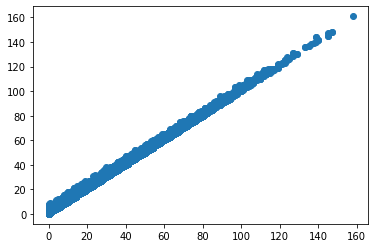

In [9]:
plt.scatter(train_df['VC_CATHA'], train_df['VC_CATHMC'])

In [10]:
train_df[['VC_CATHA', 'PX_WO_CRR6MTH']].corr()

,VC_CATHA,PX_WO_CRR6MTH
VC_CATHA,1.000000,0.031066
PX_WO_CRR6MTH,0.031066,1.000000


## PX_WO_CRR and PX_WO_CRR6MTH are duplicates

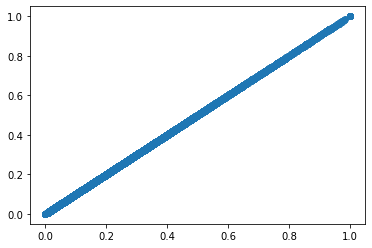

In [11]:
plt.scatter(train_df['PX_WO_CRR'], train_df['PX_WO_CRR6MTH'])

In [12]:
train_df[['PX_WO_CRR', 'PX_WO_CRR6MTH']].corr()

,PX_WO_CRR,PX_WO_CRR6MTH
PX_WO_CRR,1.0,1.0
PX_WO_CRR6MTH,1.0,1.0


In [13]:
test_df[['PX_WO_CRR', 'PX_WO_CRR6MTH']].corr()

,PX_WO_CRR,PX_WO_CRR6MTH
PX_WO_CRR,1.0,1.0
PX_WO_CRR6MTH,1.0,1.0


In [20]:
# drop duplicated column
train_df.drop(columns=['PX_WO_CRR6MTH'], inplace=True)
test_df.drop(columns=['PX_WO_CRR6MTH'], inplace=True)

## 'ax_donation_contribution_c' and other binary variables
as we can see, 'ax_donation_contribution_c' is binary variable, so we can feel it with ones and zeros

In [14]:
train_df['ax_donation_contribution_c'].value_counts(), test_df['ax_donation_contribution_c'].value_counts()

(1.0    111858
 Name: ax_donation_contribution_c, dtype: int64,
 1.0    28026
 Name: ax_donation_contribution_c, dtype: int64)

In [15]:
# print the number of unique values in each column
for col in test_df.columns:
    print(len(train_df[col].value_counts()), len(test_df[col].value_counts()))

200000 50000
185518 49087
23 23
135 122
142 126
5001 3770
5001 3770
1 1
1 1
1 1
1 1
1 1
20 20
20 20
49 49
28 28
13 13
571 449
5013 3862
4397 3387
1984 1544
5968 4454
112438 32722
60 37
128 63
128 63
1 1
1 1
1 1
2 2
10 10
3 3
2455 1821
2477 1607
6712 5784
2 2


In [16]:
# if the number of unique values is 1, then the column is binary and we fill values with 1 and NaNs with 0 
for col in test_df.columns:
    if len(train_df[col].value_counts()) == 1 and len(test_df[col].value_counts()) == 1:
        train_df[col] = train_df[col].apply(lambda x: 1 if x == x else 0)  # NaN isn't equal to itself
        test_df[col] = test_df[col].apply(lambda x: 1 if x == x else 0)

In [17]:
# check the existence of binary NaNs
for col in test_df.columns:
    print(len(train_df[col].value_counts()), len(test_df[col].value_counts()))

200000 50000
185518 49087
23 23
135 122
142 126
5001 3770
5001 3770
2 2
2 2
2 2
2 2
2 2
20 20
20 20
49 49
28 28
13 13
571 449
5013 3862
4397 3387
1984 1544
5968 4454
112438 32722
60 37
128 63
128 63
2 2
2 2
2 2
2 2
10 10
3 3
2455 1821
2477 1607
6712 5784
2 2


## Non-binary variables

In [23]:
for col in test_df.columns:
    if len(train_df[col].unique()) > 2 or len(test_df[col].unique()) > 2:
        print(col)

Unnamed: 0
VC_ID
VC_DATEMAIL
VC_CATHA
VC_CATHMC
PX_WO_CRR
ax_rfm_total_offline_orders_under_50_range_rng
ax_rfm_total_offline_orders_rng
ax_personicx_digital_cluster
ax_income_range_premium_sc
ax_income_range_broad_sc
VC_DATEMAILLAST
PX_WO_CR
ax_rfm_last_offline_purchase_date
PX_WO_CMD
VC_DATEGIFTLAST
ax_spose_income
VC_GIFTMAX1Y
PX_international_relief_CAG
PX_international_relief_CAG6MTH
ax_home_owner_type_detail_rp
ax_home_market_value_deciles_estimated_rp
ax_home_property_type_rp
PX_WO_PMD
ax_home_loan_date_3_rp_year
PX_WO_PR
ax_sex


## ax_rfm_total_offline_orders_under_50_range_rng

In [25]:
train_df['ax_rfm_total_offline_orders_under_50_range_rng'].value_counts()

K    29141
A    17677
L    14121
B    13238
C    10118
O     9125
D     8595
M     7877
E     7613
F     6685
G     5831
H     5505
N     5130
I     4879
J     4486
P     1913
Q      642
R      265
T      163
S       98
Name: ax_rfm_total_offline_orders_under_50_range_rng, dtype: int64

In [28]:
(~train_df['ax_rfm_total_offline_orders_under_50_range_rng'].notna()).sum()

46898

In [30]:
# there are a lot of NaNs, so we should fill them with a unique value
train_df['ax_rfm_total_offline_orders_under_50_range_rng'].fillna('_NaN', inplace=True)
test_df['ax_rfm_total_offline_orders_under_50_range_rng'].fillna('_NaN', inplace=True)

0            K
1            A
2         _NaN
3            L
4            C
          ... 
199995       L
199996       L
199997    _NaN
199998       O
199999    _NaN
Name: ax_rfm_total_offline_orders_under_50_range_rng, Length: 200000, dtype: object

## ax_religious_inspirational

In [ ]:
train_df['ax_religious_inspirational'].value_counts(), test_df['ax_religious_inspirational'].value_counts()

In [ ]:
train_df['ax_religious_inspirational'] = train_df['ax_religious_inspirational'].apply(lambda x: 1 if x == x else 0)
test_df['ax_religious_inspirational'] = test_df['ax_religious_inspirational'].apply(lambda x: 1 if x == x else 0)

## ax_apparel_mens_big_and_tall_c

In [ ]:
train_df['ax_apparel_mens_big_and_tall_c'].value_counts(), test_df['ax_apparel_mens_big_and_tall_c'].value_counts()

In [ ]:
train_df['ax_apparel_mens_big_and_tall_c'] = train_df['ax_apparel_mens_big_and_tall_c'].apply(lambda x: 1 if x == x else 0)
test_df['ax_apparel_mens_big_and_tall_c'] = test_df['ax_apparel_mens_big_and_tall_c'].apply(lambda x: 1 if x == x else 0)

 'VC_ID'  ---- basic id <br>
 'VC_DATEMAIL' --- the date when the person was mailed during the campaign;<br>
 'VC_DATERESP' --- the date of response for the mail (when the person donated some money ‘GIFT’) if the person responded;<br>
 'VC_GIFT'  --- TARGET (did they respond to the associated mailing) doesn’t present on validation file<br>
 'VC_CATHA',<br>
 'VC_CATHMC',<br>
 'PX_WO_CRR',<br>
 'PX_WO_CRR6MTH',<br>
 'ax_donation_contribution_c',<br>
 'ax_religious_inspirational',<br>
 'ax_apparel_mens_big_and_tall_c',<br>
 'ax_books_and_music_books_c',<br>
 'ax_adult_age_ranges_present_in_household_females_75',<br>
 'ax_rfm_total_offline_orders_under_50_range_rng',<br>
 'ax_rfm_total_offline_orders_rng',<br>
 'ax_personicx_digital_cluster',<br>
 'ax_income_range_premium_sc',<br>
 'ax_income_range_broad_sc',<br>
 'VC_DATEMAILLAST' --- the mail date of previous to the associated mailing campaign <br>
 'PX_WO_CR',<br>
 'ax_rfm_last_offline_purchase_date',<br>
 'PX_WO_CMD',<br>
 'VC_DATEGIFTLAST' --- last date responded (as of the time of this mailing)<br>
 'ax_spose_income',<br>
 'VC_GIFTMAX1Y',<br>
 'PX_international_relief_CAG',<br>
 'PX_international_relief_CAG6MTH',<br>
 'ax_scuba_diving',<br>
 'ax_adult_age_ranges_present_in_household_unknown_gender_18_24',<br>
 'ax_childrens_age_ranges_present_in_hhld_reseller_age_00_02_female',<br>
 'ax_home_owner_type_detail_rp',<br>
 'ax_home_market_value_deciles_estimated_rp',<br>
 'ax_home_property_type_rp',<br>
 'PX_WO_PMD',<br>
 'ax_home_loan_date_3_rp_year',<br>
 'PX_WO_PR',<br>
 'ax_sex'<br>

In [ ]:
(train_df['VC_GIFT'].notna()).sum()

In [ ]:
train_df['VC_GIFTMAX1Y'].notna().sum()

In [ ]:
train_df['VC_GIFTMAX1Y'].max()

In [ ]:
train_df['VC_GIFT'].max()